# Выбор локации для скважины

Заказчик - добывающая компания «ГлавРосГосНефть». 

__Цель исследования:__ построить модель, с высокой степенью вероятности определяющую объем нефти в новой скважине.

Заказчиком предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap*.

__Шаги для выбора локации:__

- В избранном регионе ищут месторождения, для каждого определяют значения признаков скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

__Описание данных:__

1. Данные геологоразведки трёх регионов находятся в файлах:

    - /datasets/geo_data_0.csv;
    - /datasets/geo_data_1.csv;
    - /datasets/geo_data_2.csv.


2. Содержание каждого файла одинаково:

    - id — уникальный идентификатор скважины;
    - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    - product — объём запасов в скважине (тыс. баррелей) - _целевой признак_.

__Условия задачи:__

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые);
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей;
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью;
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Подготовка окружения

Загрузим все потребующиеся в дальнейшей работе библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st

## Загрузка и подготовка данных

Загрузим и подготовим данные.

In [2]:
region_1 = pd.read_csv('-') # Прямая ссылка на датасет удалена в связи с правилами публикации проектов
region_2 = pd.read_csv('-') # Прямая ссылка на датасет удалена в связи с правилами публикации проектов
region_3 = pd.read_csv('-') # Прямая ссылка на датасет удалена в связи с правилами публикации проектов

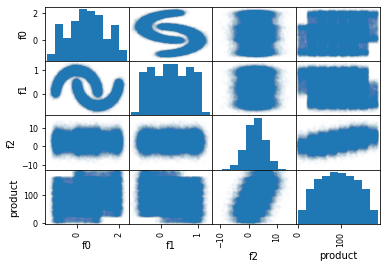

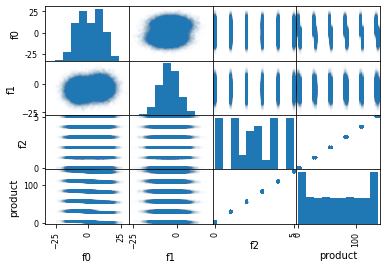

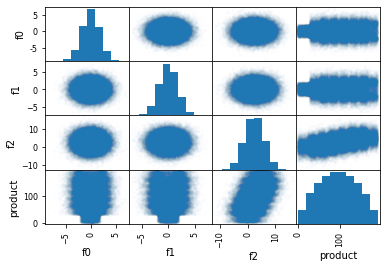

In [5]:
regions = (region_1, region_2, region_3)
for region in regions:
    pd.plotting.scatter_matrix(region, alpha=.01)
    plt.show()

Изучим значения признаков в данных с помощью «ящика с усами».

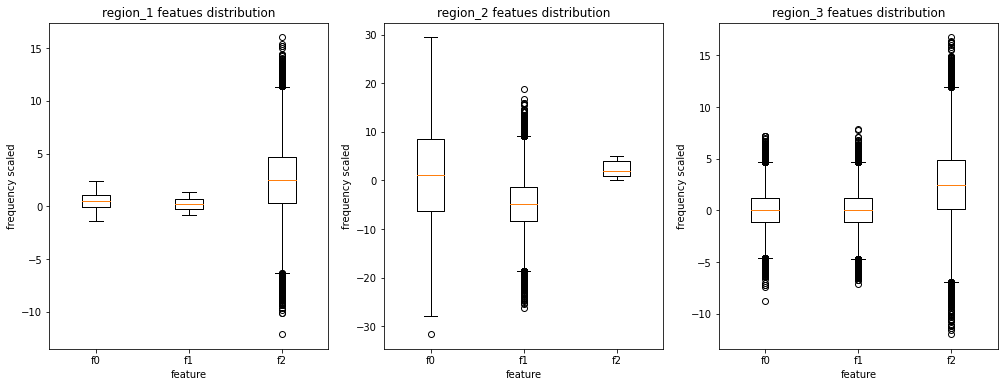

In [3]:
regions = (region_1, region_2, region_3)
fig, axs = plt.subplots(1, 3, figsize=(17, 6))
for i in range(3):
    axs[i].boxplot(regions[i][['f0', 'f1', 'f2']])
    axs[i].set_title(f'region_{i+1} featues distribution')
    axs[i].set_ylabel('frequency scaled')
    axs[i].set_xlabel('feature')
    axs[i].set_xticklabels(list(regions[i][['f0', 'f1', 'f2']].columns))

В данных есть очень заметные выбросы. Так как мы используем линейную регрессию, выбросы могут негативно повлиять на результат ее обучения. Поэтому 0.5% данных, по 0.25% с каждой стороны для признаков с выбросами.

In [4]:
region_1 = region_1[
    (region_1['f2'].quantile(.0025)<region_1['f2'])&
    (region_1['f2'].quantile(.9975)>region_1['f2'])]
region_2 = region_2[
    (region_2['f1'].quantile(.0025)<region_2['f1'])&
    (region_2['f1'].quantile(.9975)>region_2['f1'])]
region_3 = region_3[
    (region_3['f0'].quantile(.0025)<region_3['f0'])&
    (region_3['f0'].quantile(.9975)>region_3['f0'])]
region_3 = region_3[
    (region_3['f1'].quantile(.0025)<region_3['f1'])&
    (region_3['f1'].quantile(.9975)>region_3['f1'])]
region_3 = region_3[
    (region_3['f2'].quantile(.0025)<region_3['f2'])&
    (region_3['f2'].quantile(.9975)>region_3['f2'])]


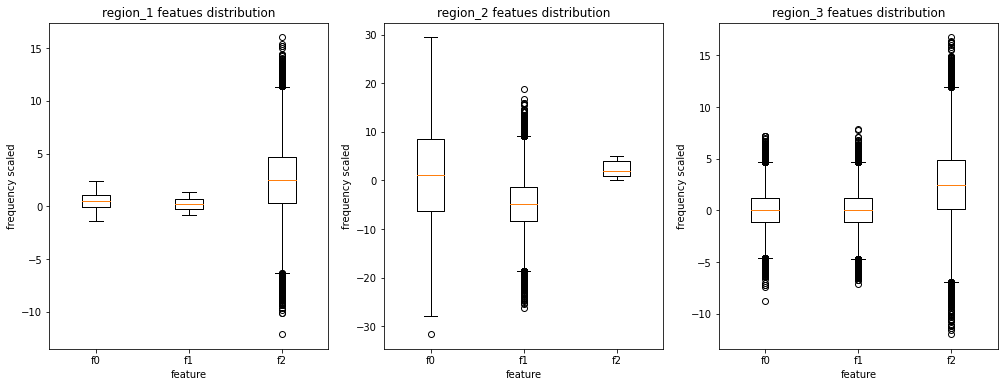

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(17, 6))
for i in range(3):
    axs[i].boxplot(regions[i][['f0', 'f1', 'f2']])
    axs[i].set_title(f'region_{i+1} featues distribution')
    axs[i].set_ylabel('frequency scaled')
    axs[i].set_xlabel('feature')
    axs[i].set_xticklabels(list(regions[i][['f0', 'f1', 'f2']].columns))

После того как значения отброшены логистическая регрессия будет меньше зависеть от экстремальных значений и точнее предсказывать объем скважины.

Также отбросим столбец `id`, так как регрессия не может работать с категориальными переменными. Не будем сбрасывать индексы - так у нас будет возможность получить значение `id` обратно на основании индекса.

In [6]:
for region in regions:
    region.drop('id', axis=1, inplace=True)

После приведения данных к единому масштабу и удаления экстремальных значений можно переходить к обучению моделей.

## Обучение и проверка модели

### Постановка задачи

В рамках этого шага для каждого из регионов необходимо:

- разделить данные для обучения и проверки модели;
- обучить модель;
- оценить качество обучения модели;

### Обучение модели

Напишем функцию, которая будет разбивать данные на обучающую и валидационную выборки, масштабировать признаки и обучать модель и возвращать предсказания для валидационной выборки.

In [7]:
def split_learn_predict(data):
    features = data.drop('product', axis=1)
    target = data['product']
    features_train, features_valid = train_test_split(features, test_size=.25, random_state=12345)
    target_train, target_valid = train_test_split(target, test_size=.25, random_state=12345)
    
    scaler = StandardScaler()
    scaler.fit(features_train[['f0', 'f1', 'f2']])
    features_train = features_train.copy()
    features_valid = features_valid.copy()
    features_train[['f0', 'f1', 'f2']] = scaler.transform(features_train[['f0', 'f1', 'f2']])
    features_valid[['f0', 'f1', 'f2']] = scaler.transform(features_valid[['f0', 'f1', 'f2']])
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    return target_valid, predicted_valid, model.score(features_valid, target_valid)

In [8]:
values = []
for region in regions:
    values.append(split_learn_predict(region))

Переходим к проверке модели.

### Проверка модели

Напишем функцию, возвращающую RMSE и средний объем сырья в скважине в регионе.

In [9]:
def model_evaluation(values):
    target = values[0]
    predictions = values[1]
    r2 = values[2]
    rmse = mean_squared_error(target, predictions) ** .5
    mean_predicted_oil_value = sum(predictions) / len(predictions)
    mean_target_oil_value = sum(target) / len(target)
    print(f'- Коэффициент детерминации R2 модели: {r2}')
    print(f'- RMSE модели: {rmse}')
    print(f'- Средний запас предсказанного сырья: {mean_predicted_oil_value}')
    print(f'- Средний запас реального сырья: {mean_target_oil_value}')
    print()

In [10]:
for i in range(3):
    print(f'Для региона {i+1}:')
    model_evaluation(values[i])

Для региона 1:
- Коэффициент детерминации R2 модели: 0.27994321524487786
- RMSE модели: 37.5794217150813
- Средний запас предсказанного сырья: 92.59256778438008
- Средний запас реального сырья: 92.07859674082941

Для региона 2:
- Коэффициент детерминации R2 модели: 0.9996233978805127
- RMSE модели: 0.893099286775617
- Средний запас предсказанного сырья: 68.7285468954458
- Средний запас реального сырья: 68.72313602437494

Для региона 3:
- Коэффициент детерминации R2 модели: 0.20524758386040443
- RMSE модели: 40.02970873393434
- Средний запас предсказанного сырья: 94.96504596800506
- Средний запас реального сырья: 94.88423280885489



### Вывод

По результатам обучения модели получились весьма противоречивые результаты. Во втором регионе модель практически гарантированно предсказывает точный показатель объема сырья, ошибка незначительная и коэффициент детерминации стремится к единице. Однако в остальных двух регионах модель показывает себя намного хуже, показывая огромную стандартную ошибку и низкий коэффициент детерминации. средний запас предсказанного и реального количества сырья у всех регионов очень близок.

## Подготовка к расчёту прибыли

В рамках этого шага необходимо рассчитать показатели для определения потенциальной прибыли. Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины.

In [11]:
BUDGET = 10 ** 10
N_WELLS = 200
BARREL_PRICE = 450
min_profit_per_well = '{:.2f}'.format((BUDGET / N_WELLS) / (BARREL_PRICE * 1000))

print(f'Минимальное количество сырья в скважине для обеспечения безубыточной разработки: {min_profit_per_well} баррелей.')

Минимальное количество сырья в скважине для обеспечения безубыточной разработки: 111.11 баррелей.


Для того что бы разработка одной скважины окупилась, ее объем должен быть не меньше 111.11 баррелей. Это значительно больше среднего значения по всем регионам, следовательно нам необходимо находить только лучшие скважины с достаточно большой вероятностью.

## Расчёт прибыли и оценка рисков

Напишем функцию, возвращающую прибыль на основе выборки предсказаний и реальных значений разведанных скважин в регионе. С ее помощью оценим средний размер прибыли, которую позволяет нам получить модель в каждом из регионов.

In [12]:
def revenue_evaluation(target, predictions, count):
    predictions = pd.Series(predictions,  target.index)
    predictions_sorted = predictions.sort_values(ascending=False).drop_duplicates()
    target_sorted = target[predictions_sorted.index][:count]
    return target_sorted.sum() * BARREL_PRICE * 1000 - BUDGET

Найдем распределение прибыли техникой Bootstrap.

In [13]:
state = np.random.RandomState(12345)
revenues = [[], [], []]
for n in range(3):
    for i in range(1000):
        subsample_target = values[n][0].sample(n=500, replace=True, random_state=state)
        subsample_predictions = pd.Series(values[n][1], values[n][0].index)[subsample_target.index]
        sum_of_revenue = revenue_evaluation(subsample_target, subsample_predictions, 200)
        revenues[n].append(sum_of_revenue)

Найдем среднюю прибыль, доверительный интервал и риск убытков.

In [14]:
for i in range(3):
    mean_revenue = sum(revenues[i]) / len(revenues[i])
    confidence_interval = (pd.Series(revenues[i]).quantile(.025), pd.Series(revenues[i]).quantile(.975))
    losses_risk = (pd.Series(revenues[i])<0).mean()
    print(f'Для региона {i+1}:')
    print(f'- Средняя прибыль: {mean_revenue}')
    print(f'- Доверительный интервал: {confidence_interval}')
    print(f'- Риск убытка: {losses_risk}')
    print()

Для региона 1:
- Средняя прибыль: 396164984.802371
- Доверительный интервал: (-111215545.89049526, 909766941.5534226)
- Риск убытка: 0.069

Для региона 2:
- Средняя прибыль: 461155817.27723974
- Доверительный интервал: (78050810.75174175, 862952060.2637234)
- Риск убытка: 0.007

Для региона 3:
- Средняя прибыль: 392950475.17060363
- Доверительный интервал: (-112227625.37857565, 934562914.5511636)
- Риск убытка: 0.065



Наибольшей средней прибыли с минимальными рисками можно достичь, разрабатывая скважины во втором регионе. Границы доверительного интервала также наиболее высокие для второго региона. 

Вкупе с высокими показателями качества модели для второго региона - можно смело рекомендовать компании рассматривать регион номер два для проведения разведки и разработки скважин. С высокой степенью вероятности результаты будут наиболее высокими именно для него.


В связи с высокими рисками не рекомендуется проводить разведку в первом и третьем регионах - риск убытков выше заданного и стабильность работы предсказательной модели недостаточно высока, что бы качественно определять перспективные скважины.